# CS 269Q: Final Project - QAOA on MIS
***
## Part 2: Using Grid Search 
Using Peter Karalekas' [notebook](https://gist.github.com/karalekas/c63b0bb24f15109f1921cea5966ca518) as reference.

__Note:__ Part 1: Using Classical Optimizer is documented on another notebook.

__GOAL:__ Generate random MIS instances for simulation on the QVM and the QPU. Benchmark against various noise models.

In [1]:
from pyquil import Program
from pyquil.gates import RESET
from pyquil.paulis import sZ, sX, sI, exponentiate_commuting_pauli_sum

def mis_ansatz(betas, gammas):
    pq = Program(RESET())
    pq += [exponentiate_commuting_pauli_sum(h_cost)(g) + exponentiate_commuting_pauli_sum(h_driver)(b) 
                for g, b in zip(gammas, betas)]
    pq.measure_all()
    return pq

In [2]:
from pyquil.gates import I, X
from pyquil.api import WavefunctionSimulator

def bit_energy(bitstring, h_cost):
    size = len(bitstring)
    pq = Program()
    for i in range(size):
        if bitstring[i] == 0:
            pq += Program(I(i))
        elif bitstring[i] == 1:
            pq += Program(X(i))
    return np.real(WavefunctionSimulator().expectation(prep_prog = pq, pauli_terms = h_cost))

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

def plot_landscape(landscape: np.ndarray, *, device: str, edges: List[Tuple[int, int]],
                   width: int, shots: int):
    max_x, max_y = (np.argmax(landscape) % width, np.argmax(landscape) // width)
    min_x, min_y = (np.argmin(landscape) % width, np.argmin(landscape) // width)
    plt.imshow(landscape, extent=[0, np.pi, np.pi, 0])
    plt.plot((max_x + 0.5) * np.pi / width, (max_y + 0.5) * np.pi / width, 'ro')
    plt.plot((min_x + 0.5) * np.pi / width, (min_y + 0.5) * np.pi / width, 'go')
    plt.colorbar()
    plt.xlabel('gamma (radians)')
    plt.ylabel('beta (radians)')
    plt.title(f'Max-Cut QAOA Landscape\n{device}\n{edges}\nwidth = {width} shots = {shots}')
    plt.show()

In [4]:
import itertools
from tqdm import tqdm
from pyquil.api import QPU, QuantumComputer

def run_mis_qaoa_landscape(qc: QuantumComputer, num_nodes, edge_list, delta, U, omega, width: int,
                              shots: int = 1000) -> np.ndarray:
   
    beta_lst = []
    gamma_lst = []
    costs = []
    angle_range = np.linspace(0, np.pi, width)
    landscape = list(itertools.product(angle_range, angle_range))
    for lst in tqdm(landscape):
        half = int(len(lst)/2)
        betas, gammas = lst[:half], lst[half:]
        
        p = mis_ansatz(betas, gammas)
        p.wrap_in_numshots_loop(shots)
        
        binary = qc.compile(p) if isinstance(qc.qam, QPU) else p
        bitstrings = qvm.run(binary)
        energy = np.mean([bit_energy(b, h_cost) for b in bitstrings])
        costs.append(energy)
        beta_lst.append(betas)
        gamma_lst.append(gammas)
        
    return costs, beta_lst, gamma_lst, np.array(costs).reshape(width, width)

In [5]:
def elist_from_math(string):
    string = string.replace(',','), (')
    string = string.replace(' <->',',')
    return eval('(' + string + ')')

In [6]:
def get_hamil(num_nodes, edge_list, delta, U, omega):
    nodes = list(range(0,num_nodes))
    edges = [(i-1,j-1) for i,j in edge_list]
    h_cost = -0.5* delta * sum((sI(i) - sZ(i)) for i in nodes) + 0.25 * U * sum((sI(i) - sZ(i))*(sI(j) - sZ(j)) for i, j in edges)
    h_driver = omega*sum(sX(i) for i in nodes) + 0.25*U * sum((sI(i) - sZ(i))*(sI(j) - sZ(j)) for i, j in edges)
    return h_cost, h_driver

In [7]:
def optimal_params(costs, beta, gamma):
    min_cost = costs[np.argmin(costs)]
    beta = beta[np.argmin(costs)]
    gamma = gamma[np.argmin(costs)]
    print("The minimum cost is:", min_cost)
    print("The optimal beta value(s):",beta)
    print("The optimal gamma value(s):",gamma)
    return beta, gamma

In [8]:
from pyquil import get_qc

# qpu = get_qc('Aspen-3-3Q-B')  # edit as necessary
qvm = get_qc('5q-qvm')  # edit as necessary

In [9]:
string = '1 <-> 2, 1 <-> 3, 1 <-> 4, 1 <-> 5, 2 <-> 3, 2 <-> 4, 2 <-> 5, 3 <-> 4, 4 <-> 5'
elist = elist_from_math(string)

width = 10
shots = 100
num_nodes = 5  # edit as necessary
delta = 1
U = 1.5
omega = 0.5

h_cost, h_driver = get_hamil(num_nodes, elist, delta, U, omega)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:10<00:00,  1.81s/it]


The minimum cost is: -0.525
The optimal beta value(s): (1.0471975511965976,)
The optimal gamma value(s): (2.443460952792061,)


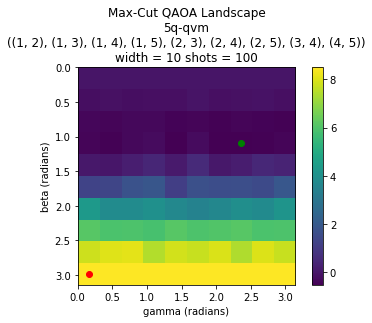

In [10]:
costs, beta, gamma, plot = run_mis_qaoa_landscape(qvm, num_nodes, elist, delta, U, omega, width, shots)
optimal_params(costs, beta, gamma)
plot_landscape(plot, device=qvm.name, edges=elist, width=width, shots=shots)

In [13]:
# SANITY CHECK
b,g = optimal_params(costs, beta, gamma)

p = Program(RESET())
p += mis_ansatz(b,g)
p.wrap_in_numshots_loop(shots)
binary = qvm.compile(p) if isinstance(qvm.qam, QPU) else p
bitstrings = qvm.run(binary)
energy = np.mean([bit_energy(b, h_cost) for b in bitstrings])
print('Calculated Cost:',energy)

The minimum cost is: -0.525
The optimal beta value(s): (1.0471975511965976,)
The optimal gamma value(s): (2.443460952792061,)
Calculated Cost: -0.415


In [ ]:
# costs, beta, gamma, plot = run_mis_qaoa_landscape(qpu, num_nodes, elist, delta, U, omega, width, shots)
# optimal_params(costs, beta, gamma)
# plot_landscape(plot, device=qvm.name, edges=elist, width=width, shots=shots)